In [1]:
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import fisher_exact

import numpy as np


import pandas as pd

import scrublet as scr

sc.set_figure_params(dpi=120)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
h5ad_obj = '../data/retreatment_patient_clustering.h5ad'

In [3]:
treatment_palette = {'first':'deepskyblue','second':'mediumseagreen'}

In [4]:
adata = sc.read(h5ad_obj)

### Fig. 6b

<AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

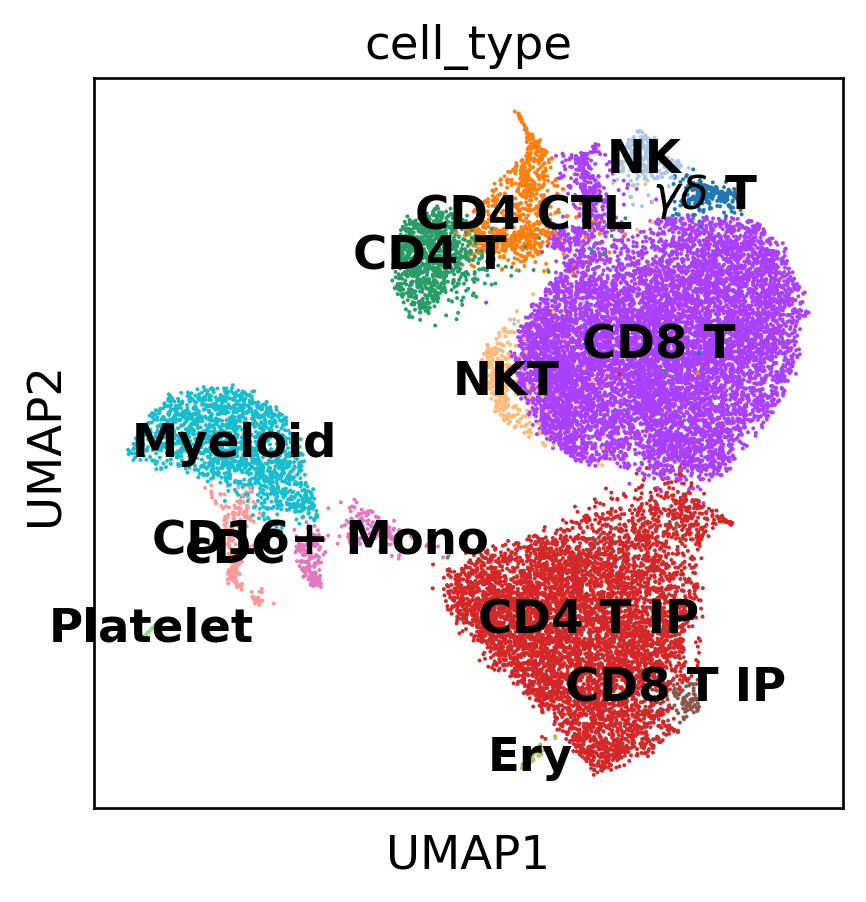

In [5]:
sc.pl.umap(adata,color='cell_type',legend_loc = 'on data',show=False)

<AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

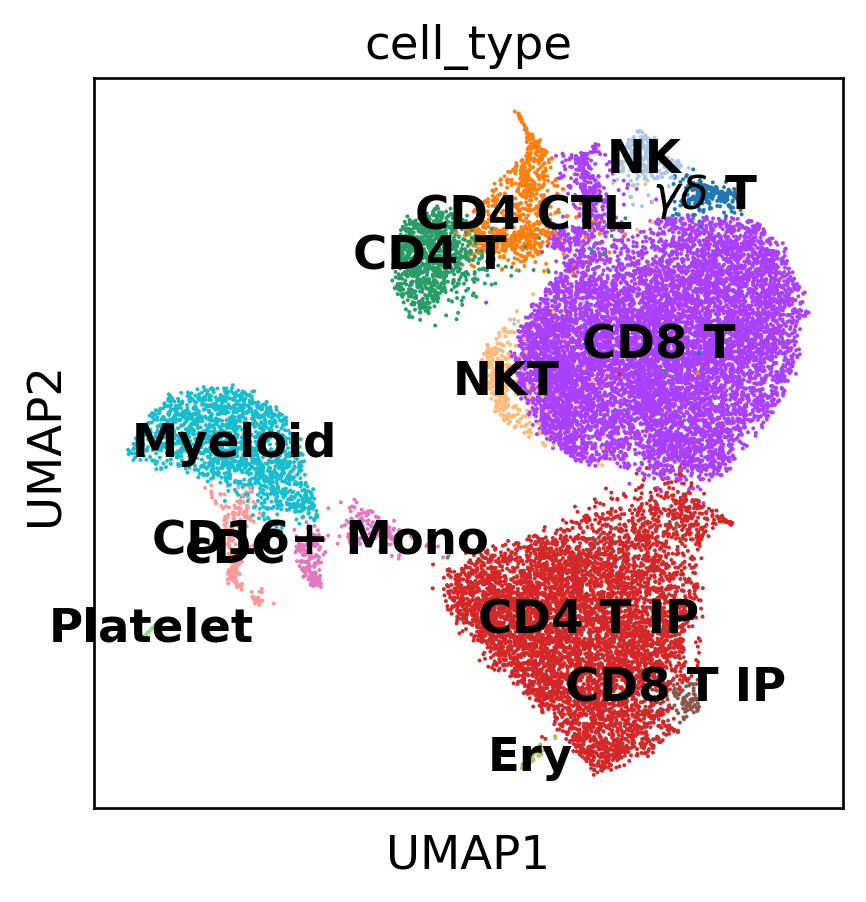

In [6]:
sc.pl.umap(adata,color='cell_type',legend_loc = 'on data',show=False)

<AxesSubplot:title={'center':'treatment'}, xlabel='UMAP1', ylabel='UMAP2'>

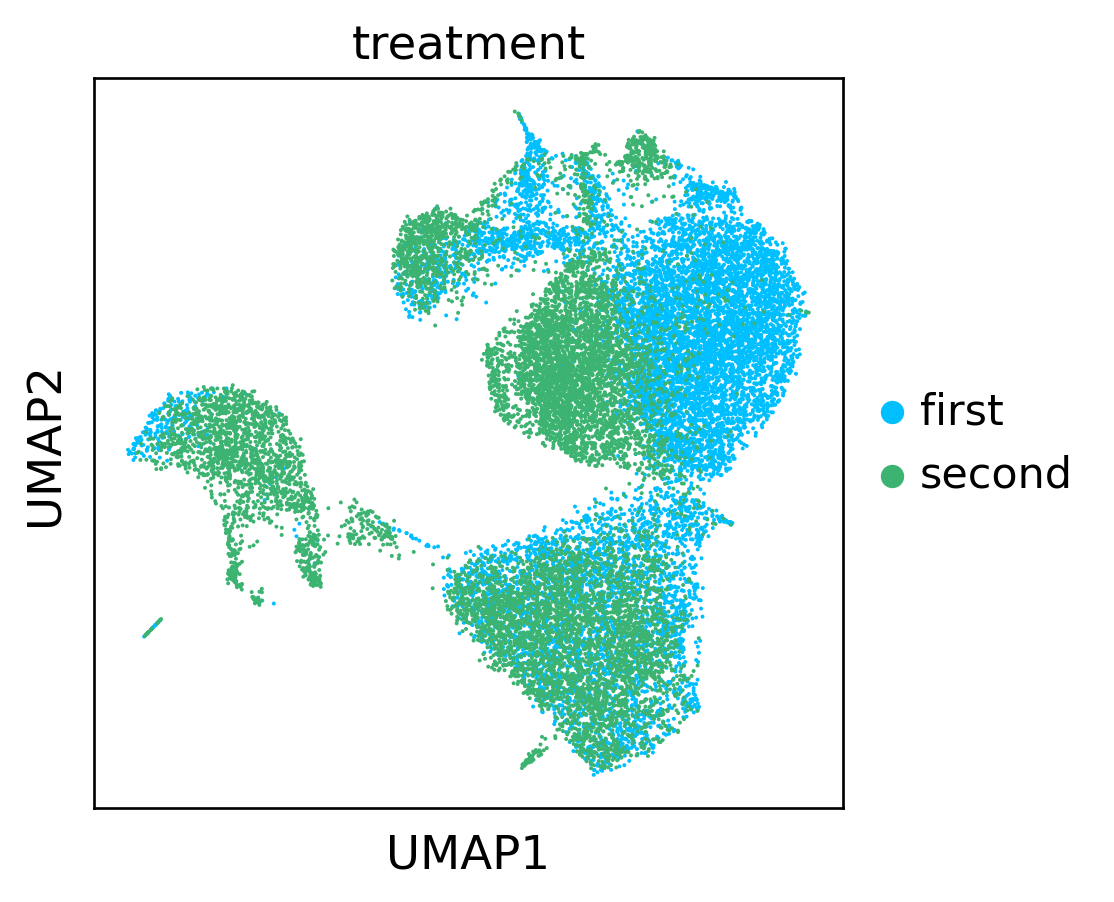

In [7]:
sc.pl.umap(adata,color='treatment',palette=treatment_palette,show=False)

### Fig. 6d

In [8]:
# Flow data
F = pd.DataFrame([[91,14,6.86],[87.4,28.1,4.87]],index=['first','second'],columns=['D7','D7-CART','Infusion']).\
    reset_index().rename(columns={'index':'treatment'}).\
    melt(id_vars='treatment',var_name='type',value_name='flow')
X = pd.crosstab([adata.obs['type'],adata.obs['treatment']],adata.obs['subtype'])[['CD4 T','CD8 T']]
X['scrna'] = X['CD8 T']/(X['CD8 T']+X['CD4 T'])*100
F=F.join(X,on=['type','treatment'])
df = F[['treatment','type','flow','scrna']].melt(id_vars=['treatment','type'],
                                                 var_name='assay',value_name='pctCD8')
df['assay'] = pd.Categorical(df['assay'],categories=['scrna','flow'])
df['type'] = pd.Categorical(df['type'].replace({'D7':'D7-nonCAR'}),categories=['Infusion','D7-CART','D7-nonCAR'])

In [9]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

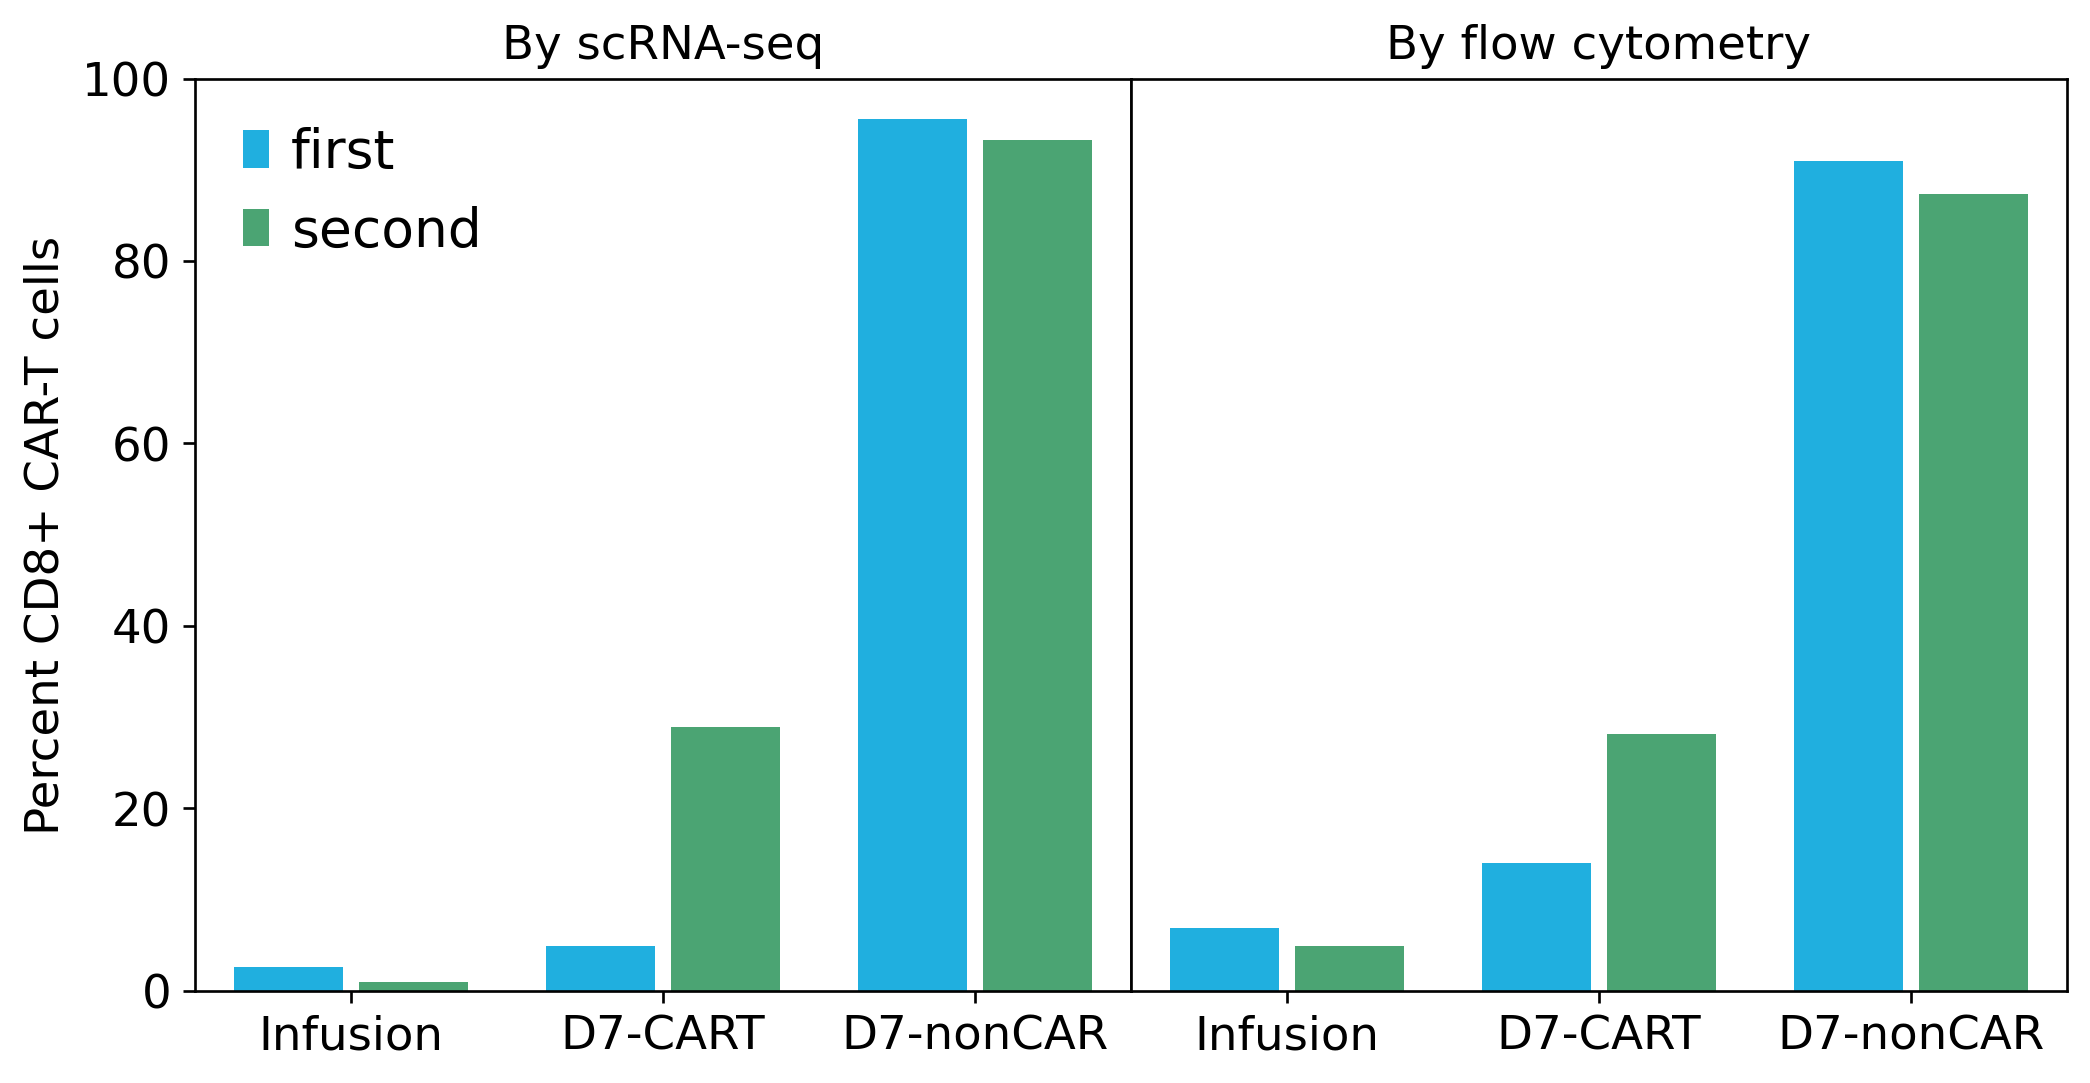

In [10]:
f,ax = plt.subplots(1,2,figsize=(10,5))

palette = {'first':'deepskyblue','second':'mediumseagreen'}

i=0
for assay,g in df.groupby('assay'):
    sns.barplot(x="type",y="pctCD8",hue="treatment",data=g,ax=ax[i],palette=palette)
    ax[i].set_ylim([0,100])
    ax[i].grid(False)
    ax[i].set_xlabel('')
    change_width(ax[i],.35)

    i+=1
ax[0].set_ylabel('Percent CD8+ CAR-T cells')
ax[1].set_ylabel('')
ax[1].set_yticks([])

ax[0].legend(frameon=False,prop={'size': 16})
ax[1].legend().remove()

ax[0].set_title('By scRNA-seq')
ax[1].set_title('By flow cytometry')
plt.subplots_adjust(wspace=0, hspace=0)

### Fig. 6f

{'heatmap_ax': <AxesSubplot:>, 'groupby_ax': <AxesSubplot:ylabel='treatment'>}

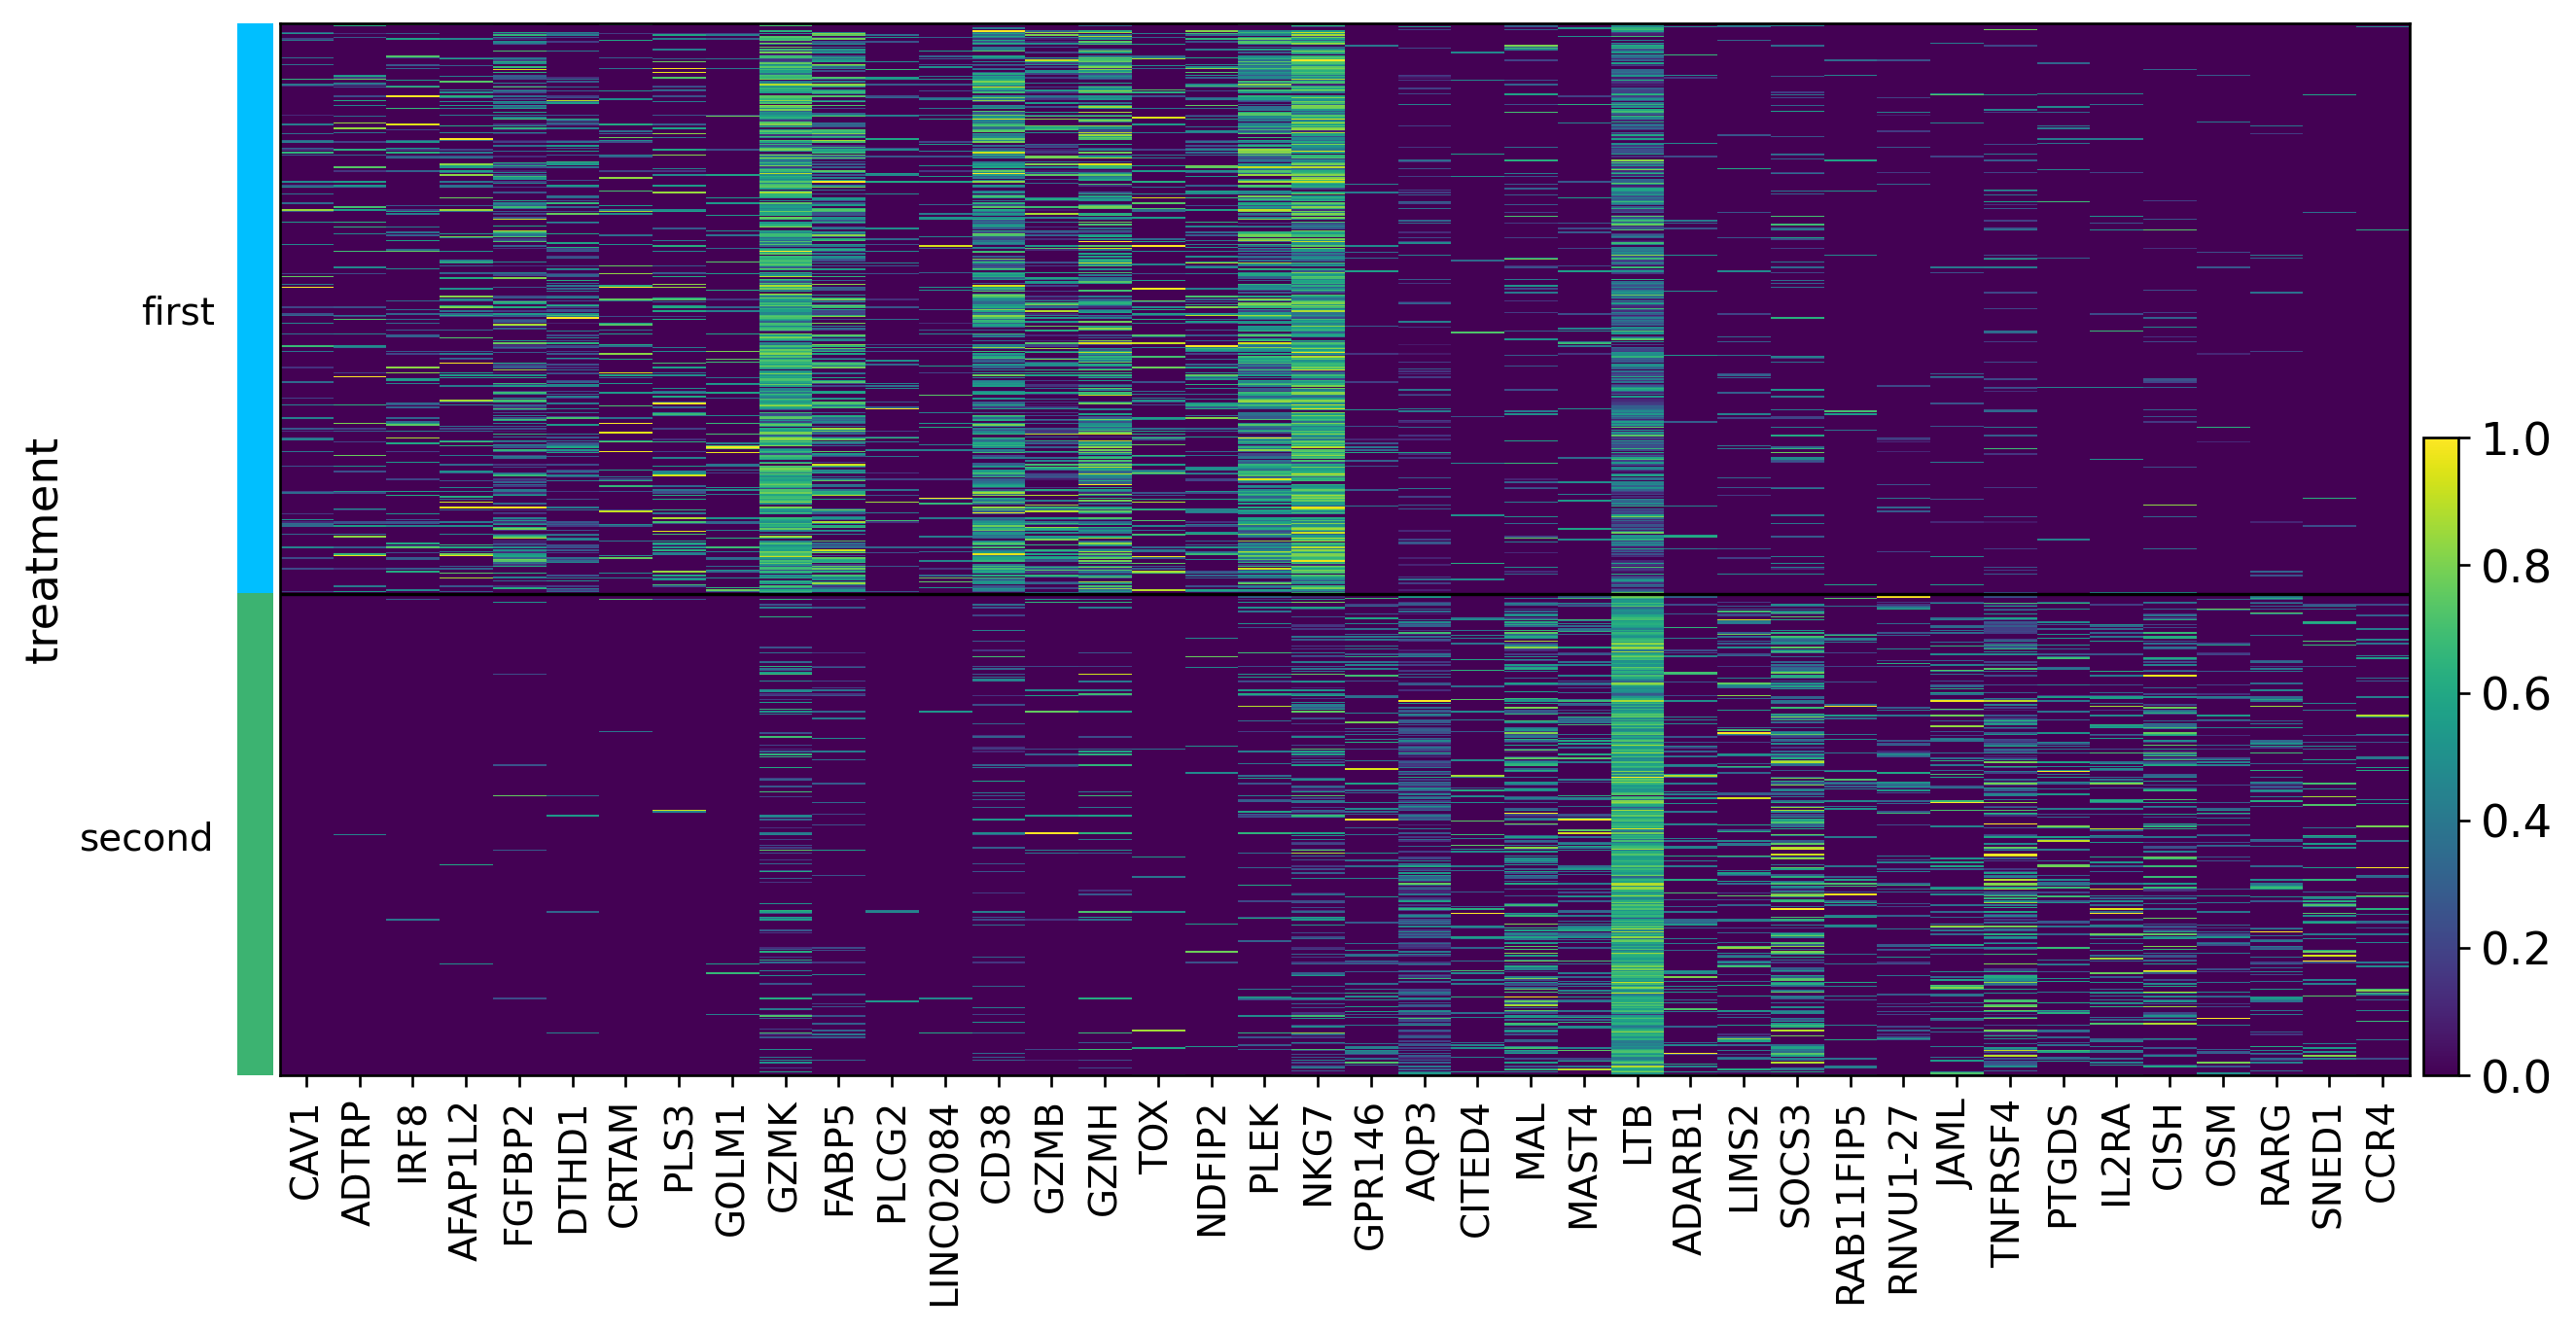

In [12]:
idx = (adata.obs['type']=='D7-CART')&(adata.obs['subtype']=='CD4 T')

adata_sub = adata[idx].copy()

sc.tl.rank_genes_groups(adata_sub,'treatment',method='wilcoxon')

df = sc.get.rank_genes_groups_df(adata_sub,'second')

# Blacklist genes in TCR/BCR genes, or those highly expressed in myeloid (probably ambient contamination)
sc.tl.rank_genes_groups(adata,'cell_type')
Mdf = sc.get.rank_genes_groups_df(adata,'Myeloid')
Mdf = Mdf[(Mdf['logfoldchanges']>3)&(Mdf['pvals_adj']<.01)]
blacklist = list(Mdf['names']) + list(adata.raw.var.index[adata.raw.var.index.str.match('TR.V|IG.V')])

df = df[~df['names'].isin(blacklist)]

df = df[df['pvals_adj']<.05]

df = df.sort_values('logfoldchanges')

gup = list(df['names'][0:20])
gdown = list(df['names'][-20:])

sc.pl.heatmap(adata_sub,gup+gdown,groupby='treatment',standard_scale='var',show=False)